In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from importlib.util import find_spec
if find_spec("qml_hep_lhc") is None:
    import sys
    sys.path.append('..')

In [52]:
import cirq
import sympy
import numpy as np
import tensorflow_quantum as tfq
import tensorflow as tf
import matplotlib.pyplot as plt
from qml_hep_lhc.data import QuarkGluon, ElectronPhoton,MNIST
from tensorflow.keras.callbacks import ReduceLROnPlateau
import argparse

from tensorflow.keras.layers import Layer, Flatten, Activation
from qml_hep_lhc.ansatzes.utils import cluster_state_circuit
import cirq
import sympy as sp
import numpy as np
from tensorflow import random_uniform_initializer, Variable, constant, repeat, tile, shape, gather, pad
import tensorflow_quantum as tfq
from tensorflow import multiply, add
from tensorflow.keras.initializers import HeUniform

from tensorflow.keras.layers import Layer, Concatenate, Reshape, Add, Activation
from qml_hep_lhc.layers.utils import normalize_padding, normalize_tuple, convolution_iters, get_count_of_qubits, get_num_in_symbols
from qml_hep_lhc.utils import _import_class
import cirq
import numpy as np
from tensorflow import pad
from qml_hep_lhc.layers import TwoLayerPQC

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dense, MaxPool2D
from qml_hep_lhc.models.base_model import BaseModel
import numpy as np
from qml_hep_lhc.layers.utils import get_count_of_qubits, get_num_in_symbols
from qml_hep_lhc.utils import _import_class

In [36]:
args = argparse.Namespace()
args.dataset_type = 'med'
args.center_crop = 0.2
args.standardize = 1
args.percent_samples = 0.05
args.optimizer = 'Ranger'

In [37]:
data = ElectronPhoton(args)
data.prepare_data()
data.setup()
print(data)

Center cropping...
Center cropping...
Standardizing data...

Dataset :Electron Photon med
╒════════╤════════════════╤═══════════════╤═══════════════╤═══════════╕
│ Data   │ Train size     │ Val size      │ Test size     │ Dims      │
╞════════╪════════════════╪═══════════════╪═══════════════╪═══════════╡
│ X      │ (360, 8, 8, 1) │ (90, 8, 8, 1) │ (50, 8, 8, 1) │ (8, 8, 1) │
├────────┼────────────────┼───────────────┼───────────────┼───────────┤
│ y      │ (360,)         │ (90,)         │ (50,)         │ (1,)      │
╘════════╧════════════════╧═══════════════╧═══════════════╧═══════════╛

╒══════════════╤═══════╤═══════╤════════╤═══════╤══════════════════════════╕
│ Type         │   Min │   Max │   Mean │   Std │ Samples for each class   │
╞══════════════╪═══════╪═══════╪════════╪═══════╪══════════════════════════╡
│ Train Images │ -2.73 │ 20.76 │   0    │  1.03 │ [180, 180]               │
├──────────────┼───────┼───────┼────────┼───────┼──────────────────────────┤
│ Val Images   │ -2.

In [38]:
# LR Scheduler callback
lr_scheduler_callback = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.1,
                                          patience=5,
                                          min_delta=0.0001,
                                          min_lr=1e-6)
callbacks = [lr_scheduler_callback]

## NQubit

In [39]:
import cirq
import sympy as sp
import numpy as np


class NQubit:

    def __init__(self):
        super().__init__()

    def __single_qubit_rot(self, qubit, symbols, sparse):
        if sparse:
            return [cirq.Y(qubit)**(symbols)]
        return [[
            cirq.Z(qubit)**symbols[i],
            cirq.Y(qubit)**symbols[i + 1],
            cirq.Z(qubit)**symbols[i + 2]
        ] for i in range(0, len(symbols), 3)]

    def build(self, qubits, feature_map, n_layers, drc, sparse,
              in_symbols=None,extras=None):

        # Observables
        Z = cirq.PauliString(cirq.Z(qubits[-1]))
        I = cirq.PauliString(cirq.I(qubits[-1]))
        observable = [-0.5 * Z + 0.5 * I]

        circuit = cirq.Circuit()
        for l in range(n_layers):
            circuit += cirq.Circuit(
                self.__single_qubit_rot(q, in_symbols[l, i], sparse)
                for i, q in enumerate(qubits))

            # Alternate CZ entangling circuit
            if (l & 1):
                circuit += [
                    cirq.CZ(q0, q1)
                    for q0, q1 in zip(qubits[1::2], qubits[2::2] + [qubits[0]])
                ]

            else:
                circuit += [
                    cirq.CZ(q0, q1)
                    for q0, q1 in zip(qubits[0::2], qubits[1::2])
                ]

        return circuit, [], [], observable

## QConv2D

In [40]:
class QConv2D(Layer):
    """
    2D Quantum convolution layer (e.g. spatial convolution over images).
    This layer creates a convolution kernel that is convolved 
    with the layer input to produce a tensor of outputs. Finally,
    `activation` is applied to the outputs as well.
    """

    def __init__(
            self,
            filters=1,
            kernel_size=(3, 3),
            strides=(1, 1),
            n_qubits=1,
            n_layers=1,
            sparse=False,
            padding='valid',
            activation='relu',
            cluster_state=False,
            fm_class='AngleMap',
            ansatz_class='Chen',
            observable=None,
            drc=False,
            ll_params = None,
            name='QConv2D',
    ):

        super(QConv2D, self).__init__(name=name)

        # Filters
        if isinstance(filters, float):
            filters = int(filters)
        if filters is not None and filters <= 0:
            raise ValueError('Invalid value for argument `filters`. '
                             'Expected a strictly positive value. '
                             f'Received filters={filters}.')
        self.filters = filters

        # Num layers
        if isinstance(n_layers, float):
            n_layers = int(n_layers)
        if n_layers is not None and n_layers <= 0:
            raise ValueError('Invalid value for argument `n_layers`. '
                             'Expected a strictly positive value. '
                             f'Received n_layers={n_layers}.')
        self.n_layers = n_layers

        self.observable = observable
        self.kernel_size = normalize_tuple(kernel_size, 'kernel_size')
        self.strides = normalize_tuple(strides, 'strides')
        self.padding = normalize_padding(padding)
        self.activation = Activation(activation)
        self.cluster_state = cluster_state
        self.fm_class = fm_class
        self.ansatz_class = ansatz_class
        self.drc = drc
        self.n_qubits = n_qubits
        self.sparse = sparse
        self.ll_params = ll_params
        
    def build(self, input_shape):

        self.iters, self.padding_constant = convolution_iters(
            input_shape[1:3], self.kernel_size, self.strides, self.padding)
        self.n_channels = input_shape[3]

        self.conv_pqcs = [[(filter, channel)
                           for channel in range(self.n_channels)]
                          for filter in range(self.filters)]

        if self.ansatz_class == 'NQubit':
            for filter in range(self.filters):
                for channel in range(self.n_channels):
                    name = f"{self.name}_{filter}_{channel}"
                    self.conv_pqcs[filter][channel] = NQubitPQC(
                        self.n_qubits, self.cluster_state, self.observable,
                        self.n_layers, self.sparse, self.ll_params, name)
        else:
            self.n_qubits = get_count_of_qubits(self.fm_class,
                                                np.prod(self.kernel_size))
            self.n_inputs = get_num_in_symbols(self.fm_class,
                                               np.prod(self.kernel_size))

            self.feature_map = _import_class(
                f"qml_hep_lhc.encodings.{self.fm_class}")()
            self.ansatz = _import_class(
                f"qml_hep_lhc.ansatzes.{self.ansatz_class}")()

            for filter in range(self.filters):
                for channel in range(self.n_channels):
                    name = f"{self.name}_{filter}_{channel}"
                    self.conv_pqcs[filter][channel] = TwoLayerPQC(
                        self.n_qubits, self.n_inputs, self.feature_map,
                        self.ansatz, self.cluster_state, self.observable,
                        self.n_layers, self.drc, name)

    def _convolution(self, input_tensor, filter, channel):

        s = self.strides
        k = self.kernel_size

        conv_out = []
        for i in range(self.iters[0]):
            for j in range(self.iters[1]):
                x = input_tensor[:, i * s[0]:i * s[0] + k[0], j *
                                 s[1]:j * s[1] + k[1]]
                conv_out += [self.conv_pqcs[filter][channel](x)]

        conv_out = Concatenate(axis=1)(conv_out)
        conv_out = Reshape((self.iters[0], self.iters[1], 1))(conv_out)
        return conv_out

    def call(self, input_tensor):
        input_tensor = pad(input_tensor, self.padding_constant)

        if self.n_channels == 1:
            conv_out = [
                self._convolution(input_tensor[:, :, :, 0], filter, 0)
                for filter in range(self.filters)
            ]

        else:
            conv_out = [
                Add()([
                    self._convolution(input_tensor[:, :, :, c], filter, c)
                    for c in range(self.n_channels)
                ])
                for filter in range(self.filters)
            ]

        conv_out = Concatenate(axis=-1)(conv_out)
        return self.activation(conv_out)

## QCNN

In [41]:
class QCNN(BaseModel):
    """
	General Quantum Convolutional Neural Network
	"""

    def __init__(self, data_config, args=None, ll_params=None):
        super(QCNN, self).__init__(args)
        self.args = vars(args) if args is not None else {}

        # Data config
        self.input_dim = data_config["input_dims"]
        self.cluster_state = self.args.get("cluster_state", False)
        self.fm_class = self.args.get("feature_map", None)
        self.ansatz_class = self.args.get("ansatz", None)
        self.n_layers = self.args.get("n_layers", 1)
        self.n_qubits = self.args.get("n_qubits", 1)
        self.sparse = self.args.get("sparse", False)

        if self.fm_class is None:
            self.fm_class = "AngleMap"
        if self.ansatz_class is None:
            self.ansatz_class = "Chen"

        self.drc = self.args.get("drc", False)

        input_shape = [None] + list(self.input_dim)

        self.qconv2d_1 = QConv2D(
            filters=1,
            kernel_size=3,
            strides=2,
            n_qubits=self.n_qubits,
            n_layers=self.n_layers,
            sparse=self.sparse,
            padding="same",
            cluster_state=self.cluster_state,
            fm_class=self.fm_class,
            ansatz_class=self.ansatz_class,
            drc=self.drc,
            ll_params = ll_params,
            name='qconv2d_1',
        )

        input_shape = self.qconv2d_1.compute_output_shape(input_shape)

        self.qconv2d_2 = QConv2D(
            filters=1,
            kernel_size=3,
            strides=2,
            n_qubits=self.n_qubits,
            n_layers=self.n_layers,
            sparse=self.sparse,
            padding="same",
            cluster_state=self.cluster_state,
            fm_class=self.fm_class,
            ansatz_class=self.ansatz_class,
            drc=self.drc,
            ll_params = ll_params ,
            name='qconv2d_2',
        )

        input_shape = self.qconv2d_2.compute_output_shape(input_shape)

        if self.ansatz_class == 'NQubit':
            self.vqc = NQubitPQC(
                self.n_qubits,
                self.cluster_state,
                None,
                self.n_layers,
                self.sparse,
                ll_params,
            )
        else:
            if ((np.prod(input_shape[1:]) > 16) and
                (self.fm_class != "AmplitudeMap")):
                print(
                    f"Will use max pooling layer since n_qubits = {np.prod(input_shape[1:])} > 16"
                )
                self.max_pool = MaxPool2D(pool_size=(2, 2))
                input_shape = self.max_pool.compute_output_shape(input_shape)

            if ((np.prod(input_shape[1:]) > 16) and
                (self.fm_class != "AmplitudeMap")):
                print(
                    f"Will use Amplitude Map since n_qubits = {np.prod(input_shape[1:])} > 16 even after max pooling"
                )
                self.fm_class = "AmplitudeMap"

            n_qubits = get_count_of_qubits(self.fm_class,
                                           np.prod(input_shape[1:]))
            n_inputs = get_num_in_symbols(self.fm_class,
                                          np.prod(input_shape[1:]))

            feature_map = _import_class(
                f"qml_hep_lhc.encodings.{self.fm_class}")()
            ansatz = _import_class(
                f"qml_hep_lhc.ansatzes.{self.ansatz_class}")()

            self.vqc = TwoLayerPQC(
                n_qubits,
                n_inputs,
                feature_map,
                ansatz,
                self.cluster_state,
                None,
                self.n_layers,
                self.drc,
            )

    def call(self, input_tensor):
        x = self.qconv2d_1(input_tensor)
        x = self.qconv2d_2(x)
        if hasattr(self, "max_pool"):
            x = self.max_pool(x)
        x = Flatten()(x)
        x = self.vqc(x)
        return x

    def build_graph(self):
        x = Input(shape=self.input_dim)
        return Model(inputs=[x],
                     outputs=self.call(x),
                     name=f"QCNN-{self.fm_class}-{self.ansatz_class}")

    @staticmethod
    def add_to_argparse(parser):
        parser.add_argument("--cluster-state",
                            action="store_true",
                            default=False)
        parser.add_argument("--feature-map", "-fm", type=str)
        parser.add_argument("--ansatz", type=str)
        parser.add_argument("--n-layers", type=int, default=1)
        parser.add_argument("--drc", action="store_true", default=False)
        parser.add_argument("--n-qubits", type=int, default=1)
        parser.add_argument("--sparse", action="store_true", default=False)
        return parser

In [42]:
model = QCNN(data.config(),args)

Using Ranger optimizer


In [54]:
args.learning_rate = 0.1
args.ansatz = 'NQubit'
args.sparse = True
args.batch_size = 64
args.cluster_state = 1
args.use_quantum = 1

n_layers_to_add = 2
args.n_layers = n_layers_to_add
args.epochs = 20
args.n_qubits = 4
n_layer_steps = 4

symbols = []
layers = []
symbol_layers = []
weights = []

training_history = []

assert ((n_layers_to_add*n_layer_steps)&1) == 0

model = QCNN(data.config(),args)
print(model.build_graph().summary(expand_nested=True))
random_weights = []
for i, l in enumerate(model.layers):
    w = model.layers[i].get_weights()
    random_weights.append(w)
for i, l in enumerate(model.layers):
    w = model.layers[i].get_weights()
    print(len(w))
    for j in w:
        print(j.shape)

args.n_layers = 0
for layer_id in range(n_layer_steps):
    print("\nLayer:", layer_id, '*'*100)
    
    args.n_layers += n_layers_to_add
    model = QCNN(data.config(),args)
    print(model.build_graph().summary(expand_nested=True))
    
    model.compile()
    # set parameters to 0 for new layers
    
    if layer_id:
        for i, _ in enumerate(model.layers):
            res = []
            for j, w in enumerate(weights[i]):
                res.append(np.append(w,random_weights[i][j]).reshape(1,-1))
            model.layers[i].set_weights(res)
    
    model.fit(data, callbacks)
    
    qnn_results = model.test(data, callbacks)
    training_history.append(qnn_results)
    
    weights = []
    for i, _ in enumerate(model.layers):
        weights.append(model.layers[i].get_weights())

Using Ranger optimizer

                                 ┌──┐
(0, 0): ───H───Y^w0───@───Y^w4─────@────
                      │            │
(0, 1): ───H───Y^w1───@───Y^w5────@┼────
                                  ││
(0, 2): ───H───Y^w2───@───Y^w6────@┼────
                      │            │
(0, 3): ───H───Y^w3───@───Y^w7─────@────
                                 └──┘


                                 ┌──┐
(0, 0): ───H───Y^w0───@───Y^w4─────@────
                      │            │
(0, 1): ───H───Y^w1───@───Y^w5────@┼────
                                  ││
(0, 2): ───H───Y^w2───@───Y^w6────@┼────
                      │            │
(0, 3): ───H───Y^w3───@───Y^w7─────@────
                                 └──┘


                                 ┌──┐
(0, 0): ───H───Y^w0───@───Y^w4─────@────
                      │            │
(0, 1): ───H───Y^w1───@───Y^w5────@┼────
                                  ││
(0, 2): ───H───Y^w2───@───Y^w6────@┼────
                      │            

KeyboardInterrupt: 

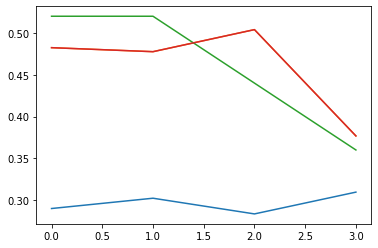

In [47]:
plt.plot(training_history)

In [48]:
for w in weights:
    print(len(w))
    for j in w:
        print(j.shape)

2
(1, 288)
(1, 32)
2
(1, 288)
(1, 32)
2
(1, 128)
(1, 32)


## NQubitPQC

In [53]:
class NQubitPQC(Layer):

    def __init__(self,
                 n_qubits,
                 cluster_state=False,
                 observable=None,
                 n_layers=1,
                 sparse=False,
                 ll_params = None,
                 name='NQubitPQC'):

        super(NQubitPQC, self).__init__(name=name)

        self.n_layers = n_layers
        self.n_qubits = n_qubits
        self.cluster_state = cluster_state
        self.observable = observable
        self.sparse = sparse
        self.activation = 'tanh'
   
        # Prepare qubits
        self.qubits = cirq.GridQubit.rect(1, self.n_qubits)
        self.ll_params = ll_params
        
        if ll_params is not None:
            self.num_partition_layers = [self.n_layers - self.ll_params[1], self.ll_params[1]]
        
        
    def build(self, input_shape):

        self.n_inputs = np.prod(input_shape[1:])

        # Make n_inputs a multiple of 3 greater than or equal to n_inputs
        if self.sparse is False:
            if self.n_inputs % 3 != 0:
                self.n_inputs += (3 - (self.n_inputs % 3))

        circuit = cirq.Circuit()

        if self.cluster_state:
            circuit += cluster_state_circuit(self.qubits)

        # Sympy symbols for (wx + b) input
        self.num_in_symbols = self.n_inputs * self.n_layers * self.n_qubits
        in_shape = (self.n_layers, self.n_qubits, self.n_inputs)
        num_weights = self.num_in_symbols
        num_biases = self.num_in_symbols

        if self.sparse:
            self.num_in_symbols = self.n_layers * self.n_qubits
            in_shape = (self.n_layers, self.n_qubits)
            num_biases = self.num_in_symbols
                
        in_symbols = sp.symbols(f'w0:{self.num_in_symbols}')
        self.in_symbols = np.asarray(in_symbols).reshape(in_shape)
            
        var_circuit, _, _, obs = NQubit().build(self.qubits, None,
                                                self.n_layers, True,
                                                self.sparse, self.in_symbols)

        if self.observable is None:
            self.observable = obs
        circuit += var_circuit

        self.in_symbols = list(self.in_symbols.flat)

        # Initalize variational angles
#         w_init = random_uniform_initializer(minval=-1, maxval=1)
#         b_init = random_uniform_initializer(minval=-0.1, maxval=0.1)
        
        w_init = HeUniform()
        b_init = HeUniform()
    
        # During set_weights The weight values should be passed in the order they are created by the layer.
        if self.ll_params is not None:
            
            t_val = self.n_qubits * self.num_partition_layers[1 - self.ll_params[0]]
            nt_val = self.n_qubits * self.num_partition_layers[self.ll_params[0]]
            
            num_t_weights = self.n_inputs * t_val 
            num_t_biases = t_val if self.sparse else self.n_inputs * t_val 
            num_nt_weights = self.n_inputs *  nt_val
            num_nt_biases = nt_val if self.sparse else self.n_inputs * nt_val
            
            qweights_init = w_init(shape=(1, num_t_weights),dtype="float32")
            qbiases_init = b_init(shape=(1, num_t_biases),dtype="float32")
            
            qntweights_init = w_init(shape=(1, num_nt_weights),dtype="float32")
            qntbiases_init = b_init(shape=(1, num_nt_biases),dtype="float32")
                
            qweights = Variable(initial_value=qweights_init,
                                     trainable=True,
                                     name=self.name + "_qweights")
            qbiases = Variable(initial_value= qbiases_init,
                                    trainable=True,
                                    name=self.name + "_qbiases")
            
            qntweights = Variable(initial_value=qntweights_init,
                                     trainable=False,
                                     name=self.name + "_qweights")
            qntbiases = Variable(initial_value= qntbiases_init,
                                     trainable=False,
                                     name=self.name + "_qweights")
            
            # specially for layer wise learning
            self.qll_wb = [
                [qntweights, qntbiases],
                [qweights, qbiases]
            ] 
        
        else:
            qweights_init = w_init(shape=(1, num_weights),dtype="float32")
            qbiases_init = b_init(shape=(1, num_biases),dtype="float32")
            
            self.qweights = Variable(initial_value=qweights_init,
                                     trainable=True,
                                     name=self.name + "_qweights")
            self.qbiases = Variable(initial_value=qbiases_init,
                                    trainable=True,
                                    name=self.name + "_qbiases")
            
        # Align Left
        circuit = cirq.align_left(circuit)
        
        print()
        print(circuit)
        print()
        
        # Define explicit symbol order
        symbols = [str(symb) for symb in self.in_symbols]
        self.indices = constant([symbols.index(a) for a in sorted(symbols)])

        # Define computation layer
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(
            circuit, self.observable)

    def call(self, input_tensor):
        batch_dim = shape(input_tensor)[0]
        x = Flatten()(input_tensor)

        # Pad input_tensor if not a multiple of 3
        if self.sparse is False:
            if x.shape[1] % 3 != 0:
                x = pad(x, [[0, 0], [0, 3 - x.shape[1] % 3]])

        tiled_up_circuits = repeat(self.empty_circuit,
                                   repeats=batch_dim,
                                   name=self.name + "_tiled_up_circuits")
        
        # Tiling inputs and multiply by weights
        if self.ll_params is not None:
            k = self.ll_params[0]
            p = self.num_partition_layers[1]
            q = self.num_partition_layers[0]
            
            p_val = self.n_qubits * p
            q_val = self.n_qubits * q
        
            tiled_up_inputp = tile(x, multiples=[1, p_val])
            tiled_up_inputq = tile(x, multiples=[1, q_val])

            tiled_up_inputp = multiply(tiled_up_inputp,
                                       self.qll_wb[1 - k][0],
                                       name=self.name + "_tiled_up_inputp_qweights")
            tiled_up_inputq = multiply(tiled_up_inputq,
                                       self.qll_wb[k][0],
                                       name=self.name + "_tiled_up_inputq_qweights")
            
        else:
            tiled_up_inputs = tile(x, multiples=[1, self.n_layers * self.n_qubits])
            tiled_up_inputs = multiply(tiled_up_inputs,
                                   self.qweights,
                                   name=self.name + "_tiled_up_inputs_qweights")
        
        # Add biases
        if self.ll_params is not None:
            if self.sparse:
                p_shape = [batch_dim, p_val, self.n_inputs]
                q_shape = [batch_dim, q_val, self.n_inputs]

                # Reshape to p_shape
                tile_up_inputp = tf.reshape(tiled_up_inputp,
                                            p_shape,
                                            name=self.name + "_reshaped_inputp")
                # Reshape to q_shape
                tile_up_inputq= tf.reshape(tiled_up_inputq,
                                            q_shape,
                                            name=self.name + "_reshaped_inputq")

                # Sum over each layer and qubit (w1*x1 + w2*x2 + ...)

                # The new shape is (batch, p_shape)
                tiled_up_inputp = tf.reduce_sum(tile_up_inputp,
                                                axis=-1,
                                                name=self.name +
                                                "_tiled_up_inputp_reduced_sum")
                # The new shape is (batch, q_shape)
                tiled_up_inputq = tf.reduce_sum(tile_up_inputq,
                                                axis=-1,
                                                name=self.name +
                                                "_tiled_up_inputp_reduced_sum")

            # Add biases
            tiled_up_inputp = add(tiled_up_inputp,
                                  self.qll_wb[1 - k][1],
                                  name=self.name +
                                  "_tiled_up_inputp_qweights_qbiases")
            tiled_up_inputq = add(tiled_up_inputq,
                                  self.qll_wb[k][1],
                                  name=self.name +
                                  "_tiled_up_inputq_qweights_qbiases")
                
            tiled_up_inputs = tf.concat([tiled_up_inputp,tiled_up_inputq], 1)
            
        elif self.sparse is False:
            tiled_up_inputs = add(tiled_up_inputs,
                                  self.qbiases,
                                  name=self.name +
                                  "_tiled_up_inputs_qweights_qbiases")
        else:
            # Reshape to (batch,n_layers*n_qubits,n_inputs)
            tile_up_inputs = tf.reshape(
                tiled_up_inputs,
                [batch_dim, self.n_layers * self.n_qubits, self.n_inputs],
                name=self.name + "_reshaped_inputs")

            # Sum over each layer and qubit (w1*x1 + w2*x2 + ...)
            # The new shape is (batch, n_layers*n_qubits)
            tiled_up_inputs = tf.reduce_sum(tile_up_inputs,
                                            axis=-1,
                                            name=self.name +
                                            "_tiled_up_inputs_reduced_sum")
            # Add biases
            tiled_up_inputs = add(tiled_up_inputs,
                                  self.qbiases,
                                  name=self.name +
                                  "_tiled_up_inputs_qweights_qbiases")
            
        tiled_up_inputs = Activation(
            self.activation)(tiled_up_inputs) * (np.pi / 2)

        joined_vars = gather(tiled_up_inputs,
                             self.indices,
                             axis=1,
                             name=self.name + "_joined_vars")
        return tf.clip_by_value(
            self.computation_layer([tiled_up_circuits, joined_vars]), 0, 1)


In [50]:
final_num_layers = n_layer_steps*n_layers_to_add
n_sweeps = 2
partition_percentage = 0.5
partition_size = int(n_layer_steps*n_layers_to_add*partition_percentage)
args.n_layers = final_num_layers

partition_weights = [[], []] # weights for two partitions

for w in weights:
    p0 = []
    p1 = []
    for j in w:
        partition = int(j.shape[1]*partition_percentage)
        p0.append(j[:,:partition].reshape(1,-1))
        p1.append(j[:,partition:].reshape(1,-1))
    partition_weights[0].append(p0)
    partition_weights[1].append(p1)
        
def create_and_train_partition(ll_params, partition_weights):
    model = QCNN(data.config(),args, ll_params)
    model.compile()
    print(model.build_graph().summary(expand_nested=True))
    
    t = ll_params[0]
    nt = 1 - t
    
    for i, _ in enumerate(model.layers):
        model.layers[i].set_weights([
            partition_weights[t][i][0],
            partition_weights[t][i][1],
            partition_weights[nt][i][0],
            partition_weights[nt][i][1]
        ])
            
    model.fit(data, callbacks)
    
    part_weights = []
    for i, _ in enumerate(model.layers):
        part_weights.append(model.layers[i].get_weights()[:2])
        
    for w in part_weights:
        print(len(w))
        for j in w:
            print(j.shape)
    
    qnn_results = model.test(data, callbacks)
    training_history.append(qnn_results)

    return part_weights

print("\nSweep over partitions\n")
for sweep in range(n_sweeps):
    # configure and train first partition
    print("\nSweep {}, partition 1\n".format(sweep+1))

    ll_params = [0,partition_size]
    
    part_weights = create_and_train_partition(ll_params, partition_weights)
    partition_weights[0] = part_weights

    # configure and train second partition
    print("\nSweep {}, partition 2\n".format(sweep+1))
          
    ll_params = [1,partition_size]

    part_weights = create_and_train_partition(ll_params, partition_weights)
    partition_weights[1] = part_weights


Sweep over partitions


Sweep 1, partition 1

Using Ranger optimizer

                                 ┌──┐                       ┌──┐                       ┌──┐                       ┌──┐
(0, 0): ───H───Y^w0───@───Y^w4─────@────Y^w8────@───Y^w12─────@────Y^w16───@───Y^w20─────@────Y^w24───@───Y^w28─────@────
                      │            │            │             │            │             │            │             │
(0, 1): ───H───Y^w1───@───Y^w5────@┼────Y^w9────@───Y^w13────@┼────Y^w17───@───Y^w21────@┼────Y^w25───@───Y^w29────@┼────
                                  ││                         ││                         ││                         ││
(0, 2): ───H───Y^w2───@───Y^w6────@┼────Y^w10───@───Y^w14────@┼────Y^w18───@───Y^w22────@┼────Y^w26───@───Y^w30────@┼────
                      │            │            │             │            │             │            │             │
(0, 3): ───H───Y^w3───@───Y^w7─────@────Y^w11───@───Y^w15─────@────Y^w19───@───Y^w23─────@

2
(1, 144)
(1, 16)
2
(1, 144)
(1, 16)
2
(1, 64)
(1, 16)
1/1 [==============================] - 1s 626ms/step - loss: 0.2674 - auc_29: 0.5312 - accuracy: 0.5200

Sweep 1, partition 2

Using Ranger optimizer

                                 ┌──┐                       ┌──┐                       ┌──┐                       ┌──┐
(0, 0): ───H───Y^w0───@───Y^w4─────@────Y^w8────@───Y^w12─────@────Y^w16───@───Y^w20─────@────Y^w24───@───Y^w28─────@────
                      │            │            │             │            │             │            │             │
(0, 1): ───H───Y^w1───@───Y^w5────@┼────Y^w9────@───Y^w13────@┼────Y^w17───@───Y^w21────@┼────Y^w25───@───Y^w29────@┼────
                                  ││                         ││                         ││                         ││
(0, 2): ───H───Y^w2───@───Y^w6────@┼────Y^w10───@───Y^w14────@┼────Y^w18───@───Y^w22────@┼────Y^w26───@───Y^w30────@┼────
                      │            │            │             │         

3/3 [==============================] - 10s 3s/step - loss: 0.1504 - auc_30: 0.9146 - accuracy: 0.8194 - val_loss: 0.3109 - val_auc_30: 0.4111 - val_accuracy: 0.4333 - lr: 1.0000e-03
2
(1, 144)
(1, 16)
2
(1, 144)
(1, 16)
2
(1, 64)
(1, 16)
1/1 [==============================] - 1s 642ms/step - loss: 0.2624 - auc_30: 0.5432 - accuracy: 0.5200

Sweep 2, partition 1

Using Ranger optimizer

                                 ┌──┐                       ┌──┐                       ┌──┐                       ┌──┐
(0, 0): ───H───Y^w0───@───Y^w4─────@────Y^w8────@───Y^w12─────@────Y^w16───@───Y^w20─────@────Y^w24───@───Y^w28─────@────
                      │            │            │             │            │             │            │             │
(0, 1): ───H───Y^w1───@───Y^w5────@┼────Y^w9────@───Y^w13────@┼────Y^w17───@───Y^w21────@┼────Y^w25───@───Y^w29────@┼────
                                  ││                         ││                         ││                         ││
(0, 2): ───H

3/3 [==============================] - 9s 3s/step - loss: 0.1697 - auc_31: 0.8657 - accuracy: 0.7583 - val_loss: 0.2891 - val_auc_31: 0.4538 - val_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 20/20
3/3 [==============================] - 9s 3s/step - loss: 0.1696 - auc_31: 0.8659 - accuracy: 0.7556 - val_loss: 0.2891 - val_auc_31: 0.4541 - val_accuracy: 0.4667 - lr: 1.0000e-04
2
(1, 144)
(1, 16)
2
(1, 144)
(1, 16)
2
(1, 64)
(1, 16)
1/1 [==============================] - 1s 678ms/step - loss: 0.2917 - auc_31: 0.4456 - accuracy: 0.4400

Sweep 2, partition 2

Using Ranger optimizer

                                 ┌──┐                       ┌──┐                       ┌──┐                       ┌──┐
(0, 0): ───H───Y^w0───@───Y^w4─────@────Y^w8────@───Y^w12─────@────Y^w16───@───Y^w20─────@────Y^w24───@───Y^w28─────@────
                      │            │            │             │            │             │            │             │
(0, 1): ───H───Y^w1───@───Y^w5────@┼────Y^w9────@───Y^w13───

3/3 [==============================] - 8s 3s/step - loss: 0.1742 - auc_32: 0.8394 - accuracy: 0.7528 - val_loss: 0.2734 - val_auc_32: 0.5393 - val_accuracy: 0.5111 - lr: 0.0100
Epoch 19/20
3/3 [==============================] - 8s 3s/step - loss: 0.1499 - auc_32: 0.9032 - accuracy: 0.8167 - val_loss: 0.2794 - val_auc_32: 0.5286 - val_accuracy: 0.5111 - lr: 0.0100
Epoch 20/20
3/3 [==============================] - 9s 3s/step - loss: 0.1455 - auc_32: 0.9150 - accuracy: 0.8194 - val_loss: 0.2778 - val_auc_32: 0.5299 - val_accuracy: 0.5000 - lr: 0.0100
2
(1, 144)
(1, 16)
2
(1, 144)
(1, 16)
2
(1, 64)
(1, 16)
1/1 [==============================] - 1s 650ms/step - loss: 0.3080 - auc_32: 0.4520 - accuracy: 0.5000


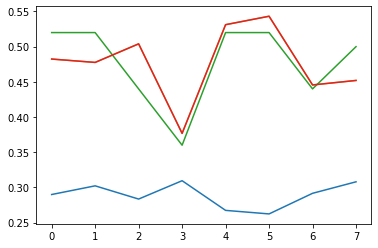

In [51]:
plt.plot(training_history)

In [17]:
for w in partition_weights[0]:
    print(len(w))
    for j in w:
        print(j.shape)

2
(1, 108)
(1, 12)
2
(1, 108)
(1, 12)
2
(1, 48)
(1, 12)


In [18]:
for w in partition_weights[1]:
    print(len(w))
    for j in w:
        print(j.shape)

2
(1, 36)
(1, 4)
2
(1, 36)
(1, 4)
2
(1, 16)
(1, 4)
